Example notebook to recreate Fig. 7 (calibrated TFR) for the EDR TF paper.

In [1]:
import numpy as np

from astropy.io import fits

import colorsys

import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.patches import Ellipse

# Data

## Galaxies

In [2]:
hdul = fits.open('fig7_data.fits')

cluster_gals = hdul[1].data
zpt_gals = hdul[2].data

hdul.close()

In [3]:
data1 = [np.log10(cluster_gals['VROT']), cluster_gals['R_MAG']]
x1_err = 0.434*cluster_gals['VROT_ERR']/cluster_gals['VROT']
y1_err = cluster_gals['R_MAG_ERR']
corr1_xy = np.zeros_like(x1_err)

data2 = [np.log10(zpt_gals['VROT']), zpt_gals['R_ABSMAG']]
x2_err = 0.434*zpt_gals['VROT_ERR']/zpt_gals['VROT']
y2_err = zpt_gals['R_ABSMAG_ERR']
corr2_xy = np.zeros_like(x2_err)

## Calibrated TFR

In [4]:
hdul = fits.open('../Fig8/fig8_data.fits')

hdr = hdul[0].header
mcmc_samples = hdul[0].data

hdul.close()

In [5]:
logV0 = hdr['LOG_V0']

m_fit = np.median(mcmc_samples[0])
b_fit = np.median(mcmc_samples[1:3], axis=1)
sig_fit = np.median(mcmc_samples[3:], axis=1)

# Plot

## Define the line perpendicular to the calibration

In [6]:
logV_n17 = (-17 - b_fit[1])/m_fit + logV0
b_perp = -17 + (logV_n17 - logV0)/m_fit


xvals = np.linspace(0.5, 3., 1000)
yvals = np.zeros((len(b_fit), len(xvals)))

for i in range(len(b_fit)):
    yvals[i] = m_fit * (xvals - logV0) + b_fit[i]
    
yvals_perp = -(xvals - logV0)/m_fit + (b_perp + b_fit[0] - b_fit[1])

## Get the 1$\sigma$ quantiles to plot with the fit

In [7]:
y_chain1 = np.outer(xvals - logV0, mcmc_samples[0]) + mcmc_samples[1]
y_chain1_quantiles = np.quantile(y_chain1, [0.1587, 0.8414], axis=1)

y_chain2 = np.outer(xvals - logV0, mcmc_samples[0]) + mcmc_samples[2]
y_chain2_quantiles = np.quantile(y_chain2, [0.1587, 0.8414], axis=1)

## Generate error ellipses

In [8]:
ells1 = [
    Ellipse(
        xy=[data1[0][i], data1[1][i]],
        width=2*y1_err[i],
        height=2*x1_err[i],
        angle=np.rad2deg(np.arccos(corr1_xy[i])),
    )
    for i in range(len(data1[0]))
]

ells2 = [
    Ellipse(
        xy=[data2[0][i], data2[1][i]],
        width=2*y2_err[i],
        height=2*x2_err[i],
        angle=np.rad2deg(np.arccos(corr2_xy[i])),
    )
    for i in range(len(data2[0]))
]

## Make the plot

In [9]:
def adjust_lightness(color, amount=0.5):
    '''
    Change the shade of the color.
    
    
    PARAMETERS
    ==========
    
    color : string or length-3 tuple
        Matplotlib color name OR rgb tuple
    
    amount : float
        Amount by which to lighten or darken the color.  Values < 1 will 
        return a darker shade, while values > 1 will return a lighter shade.  
        Default is 0.5.
    '''
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount*c[1])), c[2])

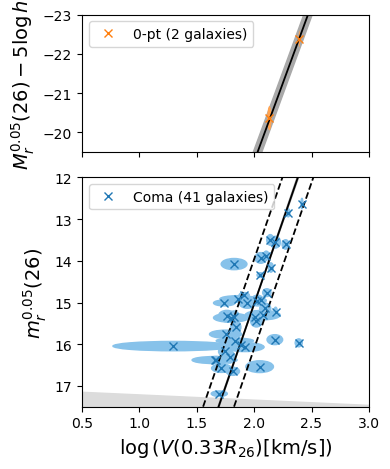

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 
                               figsize=(4,4.8), 
                               tight_layout=True, 
                               sharex=True, 
                               height_ratios=[3, 5])

################################################################################
# Coma
#-------------------------------------------------------------------------------
# Dwarf region
ax2.fill_between(xvals, 
                 yvals_perp, 
                 18, 
                 color='gainsboro')

# Calibrated TFR uncertainty
ax2.fill_between(xvals, 
                 y_chain1_quantiles[0], 
                 y_chain1_quantiles[1], 
                 color="darkgray")

# Calibrated TFR w/ Coma intercept
ax2.plot(xvals, yvals[0], "k", lw=1.3)
ax2.plot(xvals, yvals[0] - sig_fit[0], "k--", lw=1.3)
ax2.plot(xvals, yvals[0] + sig_fit[0], "k--", lw=1.3)

# Uncertainty ellipses for Coma galaxies
for i, e in enumerate(ells1):
    ax2.add_artist(e)
    e.set_color(adjust_lightness('tab:blue', amount=1.75))

# Coma galaxies
ax2.plot(data1[0], data1[1], 'x', label='Coma ({} galaxies)'.format(len(data1[0])))

ax2.set_xlabel(r"$\log{(V(0.33R_{26}) [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r^{0.05}(26)$", fontsize=14)

ax2.legend(loc='upper left')

ax2.set_xlim(0.5, 3)
ax2.set_ylim(17.5, 12)
################################################################################


################################################################################
# 0-pt calibrators
#-------------------------------------------------------------------------------
# Calibrated TFR uncertainty
ax1.fill_between(xvals, 
                 y_chain2_quantiles[0], 
                 y_chain2_quantiles[1], 
                 color='darkgray')

# Calibrated TFR
ax1.plot(xvals, yvals[1], 'k', lw=1.3)

for i, e in enumerate(ells2):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], data2[1], 'x', c='tab:orange', 
         label='0-pt ({} galaxies)'.format(len(data2[0])))

ax1.set_ylabel(r'$M_r^{0.05} (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19.5, -23);
################################################################################